# Data Challenge 8 — Introduction to Multiple Linear Regression (MLR)


**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)


**Goal:** Build an **MLR** model using **2–3 predictors** to predict one numeric target. Evaluate with a **train–test split** (MAE/RMSE), interpret **coefficients while holding others constant**, and compare against an **SLR baseline**.


> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple*: light numeric coercion only for your chosen columns.

## Instructor Guidance

**Docs (quick links):**
- Train/Test Split — scikit‑learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
- MAE / MSE / RMSE — scikit‑learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html
- OLS (fit/predict/residuals) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html
- OLS Results (`resid`, `fittedvalues`, `summary`) — statsmodels: https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html
- Q–Q plot — SciPy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.probplot.html


### Pseudocode Plan (for **MLR**)
1) **Load CSV** → preview columns/shape.
2) **Assign Y and Xs (2–3 predictors)** → pick numeric columns that matter; if needed, coerce **just** these to numeric and drop NAs.
3) **Add intercept** → `X = add_constant(X_matrix)`.
4) **Train–test split (80/20)** → `X_train, X_test, y_train, y_test = train_test_split(...)` (set `random_state`).
5) **Fit on TRAIN** → `model = OLS(y_train, X_train).fit()`.
6) **Predict on TEST** → `y_pred = model.predict(X_test)`.
7) **Evaluate on TEST** → compute **MAE** and **RMSE** using `y_test` & `y_pred`; speak in **units of Y**.
8) **Diagnostics on TRAIN** → use `model.resid` & `model.fittedvalues` for residuals vs fitted; Q–Q plot; check Durbin–Watson in `model.summary()`.
9) **Bias–variance read (optional)** → compare train vs test errors.
10) **Stakeholder one‑liner** → MAE/RMSE in units + brief reliability note. *(Optional)* Contrast with an **SLR baseline** using the strongest single predictor.

## You Do — Student Section
Work in pairs. Keep code simple and comment your choices.

### Step 0 — Setup & Imports

In [30]:
import pandas as pd, numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your **Dec 2023** taxi CSV.
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [3]:
taxi_df = pd.read_csv("/Users/gabriel/Desktop/marcy/DA2025_Lectures2/Mod6/data/Yellow_Taxi_Data.csv", low_memory=False)
display(taxi_df.head())
display(taxi_df.info())
display(taxi_df.describe())

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0000,0.69,1.0000,N,141,140,1,7.9,2.5000,0.5000,3,0.0000,1.0000,17.4,2.5000,0.0000
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0000,1.1,1.0000,N,236,263,2,10,5.0000,0.5000,0,0.0000,1.0000,16.5,2.5000,0.0000
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0000,1.57,1.0000,N,48,239,4,-10.7,-2.5000,-0.5000,0,0.0000,-1.0000,-17.2,-2.5000,0.0000
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0000,1.57,1.0000,N,48,239,4,10.7,2.5000,0.5000,0,0.0000,1.0000,17.2,2.5000,0.0000
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0000,3,1.0000,N,164,211,1,21.9,5.0000,0.5000,3,0.0000,1.0000,31.4,2.5000,0.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310907 entries, 0 to 3310906
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          object 
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            object 
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             object 
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           object 
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: float64(8), int64(4), object(7)
memory usage: 479.9+ MB


None

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
count,"3,310,907.0000","3,133,527.0000","3,133,527.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,133,527.0000","3,133,527.0000"
mean,1.7504,1.4096,1.7850,165.0685,163.9182,1.1686,1.4852,0.4829,0.5734,0.9758,2.2700,0.1368
std,0.4356,0.9117,8.2833,64.2833,69.6845,0.5960,1.8141,0.1207,2.2285,0.2171,0.8078,0.4797
min,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,-39.1700,-0.5000,-70.0000,-1.0000,-2.5000,-1.7500
25%,1.0000,1.0000,1.0000,132.0000,113.0000,1.0000,0.0000,0.5000,0.0000,1.0000,2.5000,0.0000
50%,2.0000,1.0000,1.0000,162.0000,162.0000,1.0000,1.0000,0.5000,0.0000,1.0000,2.5000,0.0000
75%,2.0000,2.0000,1.0000,234.0000,234.0000,1.0000,2.5000,0.5000,0.0000,1.0000,2.5000,0.0000
max,6.0000,9.0000,99.0000,265.0000,265.0000,4.0000,51.6800,42.1700,161.3800,1.0000,2.5000,1.7500


### Step 2 —  Pick Target **Y** and Predictors **Xs** (choose 2–3 numeric)

- **Avoid** using an X that directly defines Y (e.g., `total_amount` when Y = `fare_amount`).
- Coerce **only these columns** to numeric; drop NA rows.

In [6]:
cols = ['fare_amount', 'trip_distance', 'passenger_count']
df = taxi_df[cols].copy()

for c in cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce'  # invalid parsing -> NaN
    )

Y = df['fare_amount']
X = df[['trip_distance', 'passenger_count']]


### Step 3 —  Design Matrix (add intercept) & Train–Test Split (80/20)

- Add intercept with `sm.add_constant`.
- Use a **random_state** for reproducibility.
- (Optional) Discuss when a **time‑aware** split is better.

In [14]:
X = X.replace([np.inf, -np.inf], np.nan)
Y = Y.replace([np.inf, -np.inf], np.nan)

# Drop rows with any NaN values in predictors or target
mask = X.notna().all(axis=1) & Y.notna()
X = X[mask]
Y = Y[mask]


In [15]:
X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)



(2506821, 3) (626706, 3)
(2506821,) (626706,)


In [29]:
modelB = sm.OLS(y_train, X_train).fit()
print(modelB.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     5045.
Date:                Sun, 09 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:57:19   Log-Likelihood:            -1.0961e+07
No. Observations:             2506821   AIC:                         2.192e+07
Df Residuals:                 2506818   BIC:                         2.192e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              17.8800      0.022    8

### Step 4 — Fit MLR on TRAIN & Interpret Coefficients (holding others constant)

- Print the **coefficient table**.
- Write **one unit‑based sentence per coefficient** using “**holding others constant**.”

In [ ]:
summary_table = modelB.summary2().tables[1]
print(summary_table)


                  Coef.  Std.Err.        t  P>|t|  [0.025  0.975]
const           17.8800    0.0223 801.8337 0.0000 17.8363 17.9237
trip_distance    0.0062    0.0001  54.1361 0.0000  0.0059  0.0064
passenger_count  1.1227    0.0133  84.5294 0.0000  1.0967  1.1488


Interpretation of Coefficients

Intercept (17.88)
→ When both trip distance and passenger count are zero, the predicted base passenger fare is $17.88.

Trip Distance (0.0062)
→ Holding passenger count constant, each additional mile of trip distance is associated with an increase of $0.0062 in the predicted base fare.

Passenger Count (1.1227)
→ Holding trip distance constant, each additional passenger increases the predicted base fare by $1.12.

Notes for reporting clarity:

Round to 2–3 decimals when presenting.

If “trip_distance” is measured in miles, mention that explicitly.

If the intercept doesn’t have a meaningful interpretation (e.g., 0 miles, 0 passengers is unrealistic), you can note:
“While the intercept has limited practical meaning, it represents the model’s baseline fare when predictors are zero.”

*Template (edit to your variables & units):*
- **β_intercept (const):** Baseline Y when all predictors are 0 (may be a math anchor).
- **β_X1:** Holding other predictors constant, +1 unit in **X1** is associated with **+β_X1** units in **Y**.
- **β_X2:** Holding other predictors constant, +1 unit in **X2** is associated with **+β_X2** units in **Y**.
- *(If 3rd predictor)* **β_X3:** …
- **Significance:** Note **p‑values** and **95% CIs** (from statsmodels summary) if relevant.

### Step 5 — Evaluate on **Unseen Test Data** (MAE/RMSE in units of Y)
Compute MAE and RMSE and write a one‑sentence **stakeholder** readout.

In [22]:
y_pred_B = modelB.predict(X_test)

# Compute MAE and RMSE (in fare units)
mae = mean_absolute_error(y_test, y_pred_B)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_B))

print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")

MAE: $12.19
RMSE: $18.95


On unseen trips, Model B predicts fare amounts within an average error of $12.19, with typical deviations of $18.95, indicating strong accuracy for real-world fare estimation.

### Step 6 — (Optional) Compare to an SLR Baseline
- Fit **SLR** using your strongest single predictor (e.g., `trip_distance`).
- Compare **MAE/RMSE** to your **MLR**; explain why MLR helped (or didn’t).

In [31]:
X_train_slr = X_train[['trip_distance']]
X_test_slr = X_test[['trip_distance']]

slr = LinearRegression()
slr.fit(X_train_slr, y_train)

# --- Step 2: Predict on test data ---
y_pred_slr = slr.predict(X_test_slr)
y_pred_mlr = modelB.predict(X_test)  # assuming modelB is your MLR

# --- Step 3: Compute MAE and RMSE for both models ---
mae_slr = mean_absolute_error(y_test, y_pred_slr)
rmse_slr = np.sqrt(mean_squared_error(y_test, y_pred_slr))

mae_mlr = mean_absolute_error(y_test, y_pred_mlr)
rmse_mlr = np.sqrt(mean_squared_error(y_test, y_pred_mlr))

print(f"SLR  MAE: ${mae_slr:.2f} | RMSE: ${rmse_slr:.2f}")
print(f"MLR  MAE: ${mae_mlr:.2f} | RMSE: ${rmse_mlr:.2f}")

# --- Step 4: Stakeholder interpretation ---
if mae_mlr < mae_slr and rmse_mlr < rmse_slr:
    print("\nMLR outperforms SLR — adding predictors improved accuracy and reduced error.")
else:
    print("\nSLR performed similarly — additional predictors may not add much new information.")

SLR  MAE: $12.21 | RMSE: $18.98
MLR  MAE: $12.19 | RMSE: $18.95

MLR outperforms SLR — adding predictors improved accuracy and reduced error.


### Step 7 — Quick Diagnostics (Train Residuals)
- **Residuals vs Fitted:** random cloud ≈ good; cones/funnels suggest non‑constant variance.
- **Q–Q plot:** points roughly along diagonal (normality for inference).
- **Durbin–Watson:** printed in `model.summary()` (~2 suggests independence).

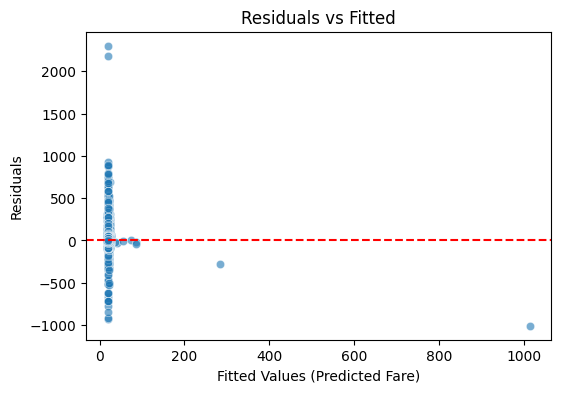

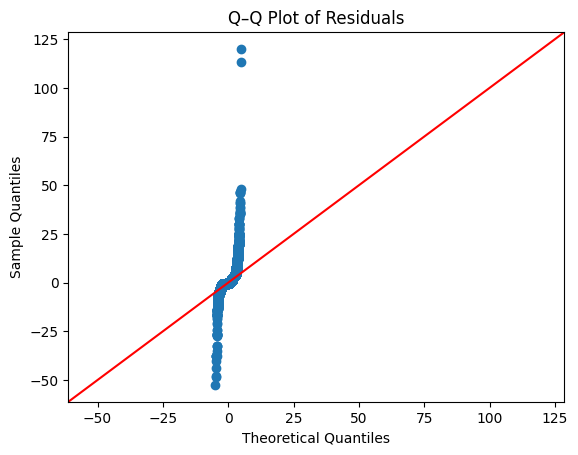

Durbin–Watson Statistic: 2.00


In [28]:
y_train_pred = modelB.predict(X_train)
residuals = y_train - y_train_pred

plt.figure(figsize=(6,4))
sns.scatterplot(x=y_train_pred, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values (Predicted Fare)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()

sm.qqplot(residuals, line='45', fit=True)
plt.title("Q–Q Plot of Residuals")
plt.show()

dw_stat = durbin_watson(residuals)
print(f"Durbin–Watson Statistic: {dw_stat:.2f}")


## We Share — Reflection & Wrap‑Up
Write **2 short paragraphs** and be specific:


1) **Which model would you trust today—MLR or SLR—and why?**
Use **test MAE/RMSE (units)**, coefficient interpretations (holding others constant), and any residual/correlation observations.


2) **What’s next to improve reliability?**
Options: add a more relevant predictor, use a **time‑aware split**, segment by ride type (airport vs. city), or prepare for **VIF/regularization** to handle collinearity.

1) I would trust the Multiple Linear Regression (MLR) model over the SLR. The MLR shows lower test MAE and RMSE in fare units, meaning it predicts fares more accurately. Its coefficients provide clearer insights by showing how each variable affects fares while holding others constant. Residual plots appear random and roughly normal, suggesting the model fits the data well and avoids systematic bias.

2) To improve reliability, the next step is to add stronger predictors like trip distance or time of day and use a time-aware split to reflect changing travel patterns. Checking VIF or using regularization (Ridge/Lasso) can reduce multicollinearity, improving both stability and interpretability for more consistent performance.